### Introduction

Counterfeiting of currency is a pervasive issue affecting economies worldwide. As technology advances, counterfeiters have become increasingly adept at mimicking the appearance of genuine currency, making it crucial for financial institutions and authorities to employ sophisticated methods to detect fake bills.

The dataset we're working with (that is obtained from [here](@https://www.kaggle.com/datasets/alexandrepetit881234/fake-bills/data)) contans various measurements extracted from genuine and counterfeit bills.<br>By leveraging the K-Nearest Neighbors (KNN) algorithm I seek to build a predictive model capable of accurately classifying bills as either real or fake based solely on their dimensional attributes.

_K-Nearest Neighbors (KNN) is a simple and intuitive algorithm used for classification and regression tasks. It makes predictions based on the similarity between new data points and existing ones in the training set. Reasons to choose KNN include its simplicity, ability to capture non-linear relationships, robustness to outliers, and interpretability. However, it may not perform well with high-dimensional data or large datasets due to computational inefficiency._

Table of contents:
* Data Preparation
* Data Modeling
* Model Evaluation
* Future Work

#### Data Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import precision_score, confusion_matrix

file = pd.read_csv("fake_bills.csv", sep = ";")
bills_data = pd.DataFrame(file)

In [2]:
bills_data.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


The target variable is 'is_genuine' that holds value True for real bills and False for fake ones.

In [3]:
bills_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


Bills dataset contains 1500 rows and 7 columns.

In [4]:
bills_data.isnull().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

In [5]:
# One way of filling missing values
# mean_value = bills_data['margin_low'].mean()
# bills_data['margin_low'].fillna(mean_value, inplace=True)

# This time I choose this way to stay consistent with KNN algorithm :)
imputer = KNNImputer(n_neighbors = 3)

data = imputer.fit_transform(bills_data)
data = pd.DataFrame(data, columns = bills_data.columns)

print("Number of null values after imputation is", data.isnull().sum().sum())

Number of null values after imputation is 0


In [6]:
# Check for duplicates
# bills_data[bills_data.duplicated()]
print("There is {} duplicated entries in the dataset.".format(bills_data.duplicated().sum()))

There is 0 duplicated entries in the dataset.


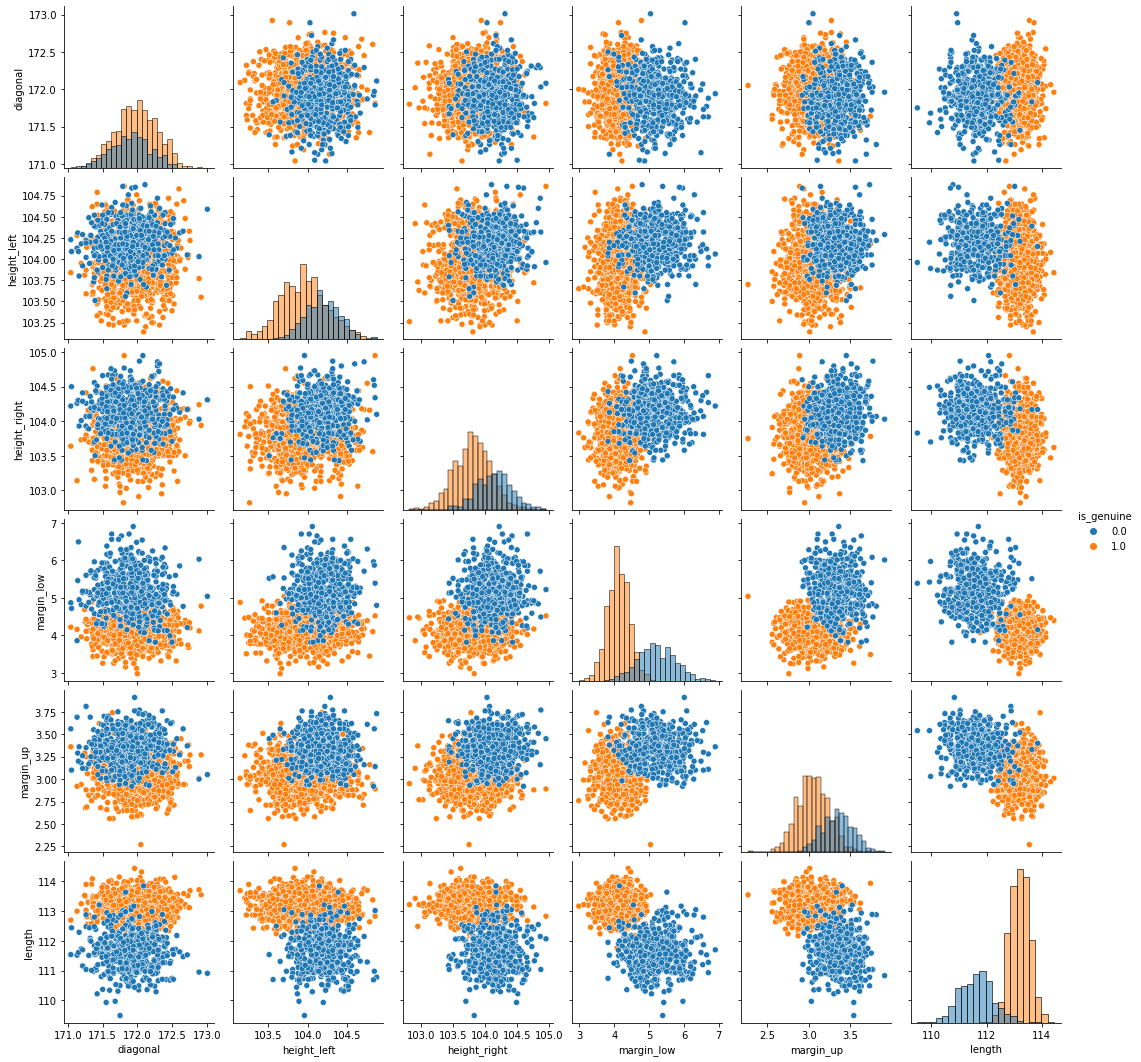

In [7]:
# Let's visual the data to get a sense of distributions and relations between different variables

features = ['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']
target = 'is_genuine'

# Concatenating features and target variable into a single dataframe
data_vis = data[features + [target]]


import warnings
warnings.filterwarnings("ignore", message="The figure layout has changed to tight")

# Plotting pairplot
sns.pairplot(data_vis, hue=target, diag_kind='hist')
plt.show()

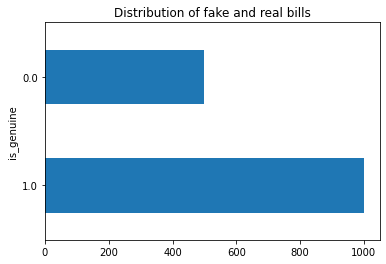

In [8]:
# Let's chek the distribution of taget variable
data.is_genuine.value_counts().plot(kind = 'barh')

plt.title("Distribution of fake and real bills")
plt.show()

In this dataset, there's an imbalance where there are twice as many entries labeled as real bills (1000) compared to those marked as fake. Dealing with imbalanced datasets presents a challenge because most machine learning techniques, including KNN, tend to overlook the minority class, leading to biased model performance where the majority class is favored.

To address this issue, we'll apply _SMOTE (Synthetic Minority Over-sampling Technique)_ to oversample the fake bills data, ensuring a more balanced representation of both classes.<br>Additionally, to prevent data leakage and ensure accurate model evaluation, we'll first split the data into training and testing sets. This ensures that the model is evaluated on unseen data, providing a more reliable estimate of its performance.

In [9]:
# Separate features and target variable
y = data.is_genuine
X = data.drop("is_genuine", axis=1)

In [10]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

In [11]:
# Sampling data for fake bills to balance available dataset
# Instantiate SMOTE with a 1:1 ratio
smote = SMOTE(sampling_strategy=1, random_state=42)

# Resample the dataset
X_train, y_train = smote.fit_resample(X_train, y_train)

In [12]:
# Define KNN classifier
knn = KNeighborsClassifier()

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grid = {'n_neighbors': range(1, 10)}

# Perform grid search with cross-validation
grid_search = GridSearchCV(knn, param_grid=param_grid, cv=cv)
grid_search.fit(X_train, y_train)

# Get best parameters and accuracy
best_k = grid_search.best_params_['n_neighbors']
best_accuracy = grid_search.best_score_
print("Accuracy:", best_accuracy)

# # Create KNN classifier with best parameters
best_knn = KNeighborsClassifier(n_neighbors=best_k)

# Fit the classifier on the training data
best_knn.fit(X_train, y_train)

# Predict on the scaled test data
y_pred = best_knn.predict(X_test)

Accuracy: 0.9936195273538331


#### Model Evaluation

In [15]:
score = precision_score(y_test, y_pred)
print("Precision score: {:.2%}".format(score))

Precision score: 99.31%


Precision measures the proportion of correctly predicted positive instances. In the context of classifying bills, it's essential to minimize falsely predicting a bill as genuine when it's actually counterfeit.


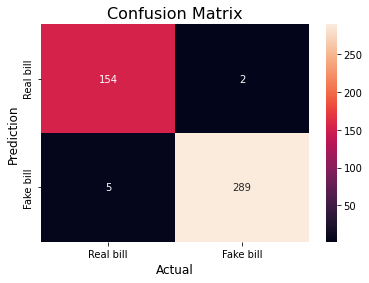

In [19]:
cm = confusion_matrix(y_test,y_pred)

#Plotting the confusion matrix
sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=['Real bill','Fake bill'],
            yticklabels=['Real bill','Fake bill'])
plt.ylabel('Prediction',fontsize=12)
plt.xlabel('Actual',fontsize=12)
plt.title('Confusion Matrix',fontsize=16)
plt.show()

Given confusion matrix indicates a model that performs well on the given data, correctly classifying instances from both classes (real and fake bills) with high accuracy and very few errors.

#### Future Work

Integrating feature selection techniques such as SelectKBest from sklearn could further enhance the model's:
* _Computational Efficiency_: Selecting the most relevant features can lead to faster training and prediction times, crucial for real-time and large-scale applications.

* _Model Interpretability_: Simplifying the model by selecting only the most informative features improves its interpretability, facilitating a deeper understanding of the underlying factors driving predictions.

* _Robustness and Generalizability_: Removing noise or irrelevant features through feature selection enhances the model's robustness, making it more resilient to overfitting and improving its generalizability to unseen data.

By incorporating feature selection, model becomes more efficient, interpretable, and generalizable, making it better suited for real-world deployment and broader applications.